In [168]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import ast
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

# Loading in the data sets

In [169]:
credits_df = pd.read_csv('dataset/credits.csv')
titles_df = pd.read_csv('dataset/titles.csv')

## Credits data frame
This data frame shows the actors and directors with their respective movies and shows

In [170]:
credits_df.head()

,person_id,id,name,character,role
0,3748,tm84618,Robert De Niro,Travis Bickle,ACTOR
1,14658,tm84618,Jodie Foster,Iris Steensma,ACTOR
2,7064,tm84618,Albert Brooks,Tom,ACTOR
3,3739,tm84618,Harvey Keitel,Matthew 'Sport' Higgins,ACTOR
4,48933,tm84618,Cybill Shepherd,Betsy,ACTOR


## Titles data frame
This data frame shows the attributes relating to each movie or show with their corresponding imdb scores

In [171]:
titles_df.head()

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,51,['documentation'],['US'],1.0,NaN,NaN,NaN,0.600,NaN
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],NaN,tt0075314,8.2,808582.0,40.965,8.179
2,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,"['drama', 'action', 'thriller', 'european']",['US'],NaN,tt0068473,7.7,107673.0,10.010,7.300
3,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,tt0071853,8.2,534486.0,15.461,7.811
4,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,NaN,150,"['war', 'action']","['GB', 'US']",NaN,tt0061578,7.7,72662.0,20.398,7.600


## Differences between the two data frames
Here we discover that some movies/shows from the titles data frame do not appear in the credits data frame.
There movies and shows will get automatically removed on merge.

In [172]:
# Remove all duplicates
credits_movie_ids = set(credits_df['id'])
titles_movie_ids = set(titles_df['id'])

# Find movie/shows ids that are in titles but not in credits
media_not_in_credits = titles_df[~titles_df['id'].isin(credits_movie_ids)]
print(len(media_not_in_credits))

361


## Group all actors and directors with their respective media
This will give us a list of all actors and directors for each movie and show

In [173]:
# Group by movie id and aggregate the data into lists
grouped_credits_df = credits_df.groupby('id').agg({
    'person_id': lambda x: list(x),
    'name': lambda x: list(x),
    'character': lambda x: list(x),
    'role': lambda x: list(x)
}).reset_index()

# Separate actors and directors into new columns
grouped_credits_df['actor'] = [[name for name, role in zip(names, roles) if role == 'ACTOR'] for names, roles in zip(grouped_credits_df['name'], grouped_credits_df['role'])]
grouped_credits_df['director'] = [[name for name, role in zip(names, roles) if role == 'DIRECTOR'] for names, roles in zip(grouped_credits_df['name'], grouped_credits_df['role'])]

# Create new columns for actor_ids and director_ids
grouped_credits_df['actor_ids'] = [[pid for pid, role in zip(pids, roles) if role == 'ACTOR'] for pids, roles in zip(grouped_credits_df['person_id'], grouped_credits_df['role'])]
grouped_credits_df['director_ids'] = [[pid for pid, role in zip(pids, roles) if role == 'DIRECTOR'] for pids, roles in zip(grouped_credits_df['person_id'], grouped_credits_df['role'])]

# Drop unnecessary columns
grouped_credits_df.drop(['name', 'role', 'person_id'], axis=1, inplace=True)
grouped_credits_df

,id,character,actor,director,actor_ids,director_ids
0,tm1000037,"[Maxi, Karl, Alex, Ante, Jitka, Pankraz, Didie...","[Luna Wedler, Jannis Niewöhner, Milan Peschel,...",[Christian Schwochow],"[251702, 41192, 589580, 191901, 237433, 76618,...",[142171]
1,tm1000147,"[David Carmichael, Jane, Marlon Veidt, Joseph ...","[Guy Pearce, Matilda Anna Ingrid Lutz, Travis ...",[Andrew Baird],"[5080, 159223, 35608, 595294, 9714, 60547, 772...",[954232]
2,tm100015,"[Gordon Jennings, John Rahway, Jack Welles, Ja...","[Idris Elba, Paul Walker, Matt Dillon, Michael...",[John Luessenhop],"[1675, 2673, 13138, 5130, 13145, 13137, 10712,...",[13150]
3,tm1000166,"[Himself, Himself, Herself, Herself, Himself, ...","[Glenn Fredly, Marcello Tahitoe, Andien Aisyah...",[Saron Sakina],"[248002, 1793972, 930514, 1794044, 1793676, 24...",[1793832]
4,tm1000185,"[Monika/Klaudia, Enzo, Ojciec Moniki, Ilona, J...","[Adrianna Chlebicka, Mateusz Banasiuk, Mirosła...",[Filip Zylber],"[1562688, 299215, 106368, 254540, 97525, 20121...",[446979]
...,...,...,...,...,...,...
5484,ts97584,"[Himself - Host, nan]",[Sebastian Perry],[William Mitchell],[1323916],[1324096]
5485,ts9794,[Self - Host],[Jerry Seinfeld],[],[32954],[]
5486,ts98252,"[Skipper (voice), Rico the Penguin (voice), Me...","[Tom McGrath, John DiMaggio, David Schwimmer, ...",[],"[9240, 1950, 9232, 22676, 5664, 8709, 916, 630...",[]
5487,ts98316,[Narrator],[John Hurt],[],[4824],[]


## Merge the two data frames into one data frame

In [174]:
# Merge titles dataframe with grouped credits dataframe
media_df = pd.merge(titles_df, grouped_credits_df, left_on = "id", right_on = "id")

media_df

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,character,actor,director,actor_ids,director_ids
0,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],NaN,tt0075314,8.2,808582.0,40.965,8.179,"[Travis Bickle, Iris Steensma, Tom, Matthew 'S...","[Robert De Niro, Jodie Foster, Albert Brooks, ...",[Martin Scorsese],"[3748, 14658, 7064, 3739, 48933, 32267, 519612...",[3308]
1,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,"['drama', 'action', 'thriller', 'european']",['US'],NaN,tt0068473,7.7,107673.0,10.010,7.300,"[Ed Gentry, Lewis Medlock, Bobby Trippe, Drew ...","[Jon Voight, Burt Reynolds, Ned Beatty, Ronny ...",[John Boorman],"[10103, 13020, 6639, 11224, 24509, 80069, 8403...",[17727]
2,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,tt0071853,8.2,534486.0,15.461,7.811,[King Arthur / Voice of God / Middle Head / Hi...,"[Graham Chapman, John Cleese, Eric Idle, Terry...","[Terry Jones, Terry Gilliam]","[11472, 1549, 11474, 11473, 11475, 11476, 4089...","[11475, 11473]"
3,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,NaN,150,"['war', 'action']","['GB', 'US']",NaN,tt0061578,7.7,72662.0,20.398,7.600,"[Maj. John Reisman, Maj. Gen. Worden, Joseph W...","[Lee Marvin, Ernest Borgnine, Charles Bronson,...",[Robert Aldrich],"[35196, 1050, 16868, 14351, 35197, 35200, 1061...",[1063]
4,ts22164,Monty Python's Flying Circus,SHOW,A British sketch comedy series with the shows ...,1969,TV-14,30,"['comedy', 'european']",['GB'],4.0,tt0063929,8.8,73424.0,17.617,8.306,"[Various, Various / ""It's"" man, Various, Vario...","[Graham Chapman, Michael Palin, Terry Jones, E...",[],"[11472, 11476, 11475, 11474, 11473]",[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5484,tm1216735,Sun of the Soil,MOVIE,"In 14th-century Mali, an ambitious young royal...",2022,NaN,26,[],[],NaN,NaN,NaN,NaN,1.179,7.000,[nan],[],[Joe Penney],[],[1785287]
5485,tm985215,Princess 'Daya'Reese,MOVIE,Reese is a con artist from Manila who dreams o...,2021,NaN,115,"['comedy', 'romance']",['PH'],NaN,tt13399802,7.1,50.0,1.383,NaN,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[Maymay Entrata, Edward Barber, Snooky Serna, ...",[Barry Gonzalez],"[757428, 757395, 134442, 143411, 206514, 26073...",[753271]
5486,tm1097142,My Bride,MOVIE,The story follows a young man and woman who go...,2021,NaN,93,"['romance', 'comedy', 'drama']",['EG'],NaN,tt14216488,5.0,327.0,2.545,5.300,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[Ahmed Hatem, Jamila Awad, Mahmoud Al-Bezzawy,...",[Mohamed Bakir],"[247928, 710979, 1813868, 817494, 1459769, 119...",[1827884]
5487,tm1014599,Fine Wine,MOVIE,A beautiful love story that can happen between...,2021,NaN,100,"['romance', 'drama']",['NG'],NaN,tt13857480,6.8,45.0,1.466,NaN,"[Mr. George, Kaima, Akin, Tunji, Temisan, nan,...","[Richard Mofe-Damijo, Ego Nwosu, Keppy Ekpenyo...",[Seyi Babatope],"[269015, 2151684, 361605, 1018894, 618764, 678...",[1962840]


# A look at the data structure

## Summary of all numerical attributes

In [175]:
media_df.describe()

,release_year,runtime,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
count,5489.000000,5489.000000,1840.000000,5063.000000,5.049000e+03,5487.000000,5317.000000
mean,2016.346147,78.995263,2.227717,6.503279,2.464454e+04,23.417779,6.804581
std,7.010669,38.574447,2.807934,1.155218,9.822354e+04,83.486521,1.138524
min,1954.000000,0.000000,1.000000,1.500000,5.000000e+00,0.600000,1.000000
25%,2016.000000,46.000000,1.000000,5.800000,6.080000e+02,2.902500,6.100000
50%,2018.000000,86.000000,1.000000,6.600000,2.523000e+03,7.095000,6.900000
75%,2020.000000,105.000000,2.000000,7.300000,1.055600e+04,17.262500,7.500000
max,2022.000000,240.000000,42.000000,9.500000,2.294231e+06,2274.044000,10.000000


## Description of the data so far

In [176]:
media_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5489 entries, 0 to 5488
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    5489 non-null   object 
 1   title                 5488 non-null   object 
 2   type                  5489 non-null   object 
 3   description           5481 non-null   object 
 4   release_year          5489 non-null   int64  
 5   age_certification     2990 non-null   object 
 6   runtime               5489 non-null   int64  
 7   genres                5489 non-null   object 
 8   production_countries  5489 non-null   object 
 9   seasons               1840 non-null   float64
 10  imdb_id               5120 non-null   object 
 11  imdb_score            5063 non-null   float64
 12  imdb_votes            5049 non-null   float64
 13  tmdb_popularity       5487 non-null   float64
 14  tmdb_score            5317 non-null   float64
 15  character            

## Ratings count
Here we see how many rows belong to each rating

In [177]:
media_df['imdb_score'].value_counts()

imdb_score
6.5    195
7.1    190
6.7    188
7.4    186
6.3    179
      ... 
1.5      1
9.5      1
9.2      1
1.6      1
1.7      1
Name: count, Length: 78, dtype: int64

# Start EDA

## Histogram

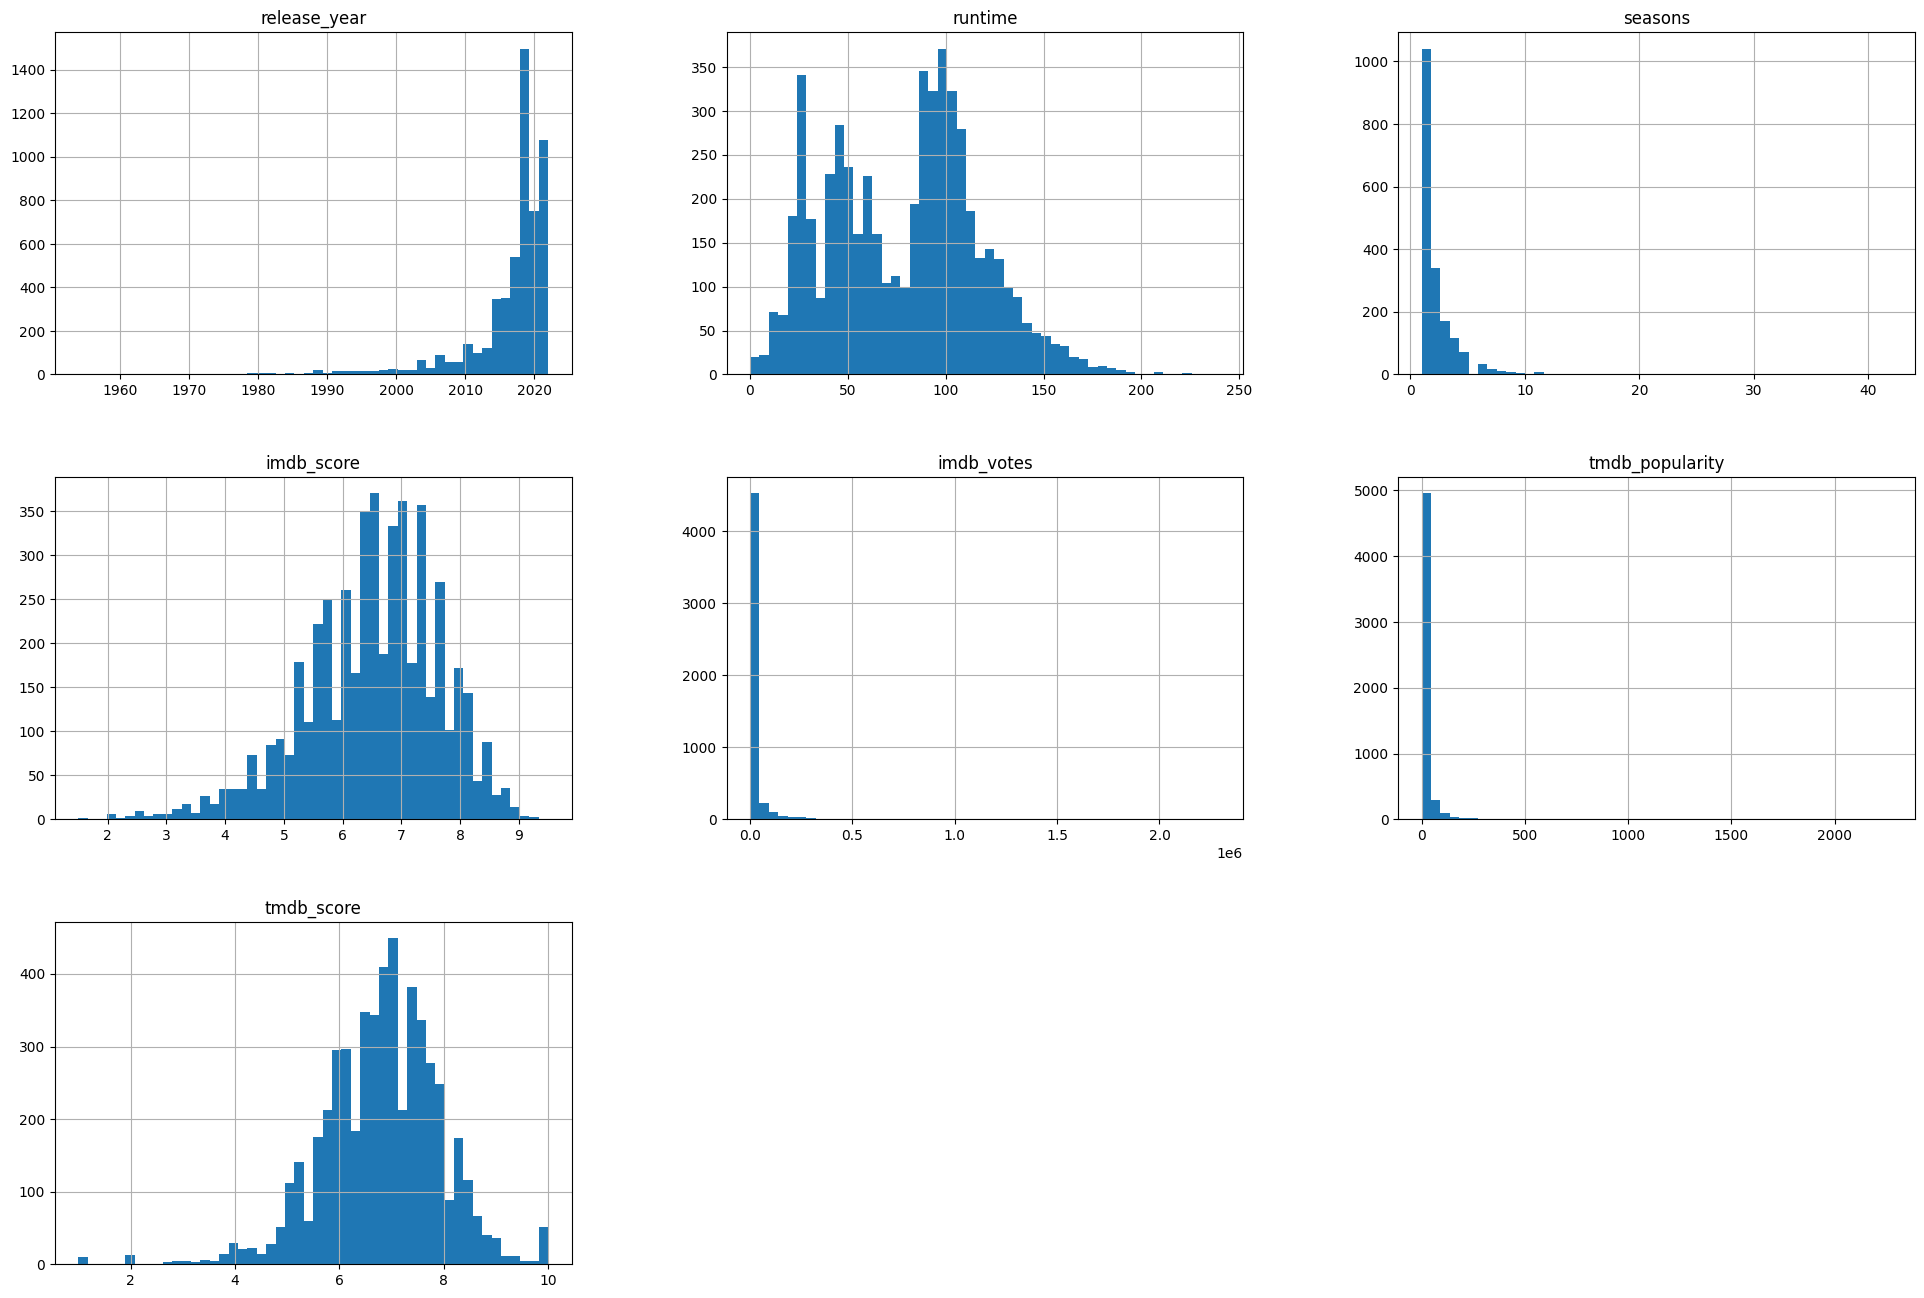

In [178]:
media_df.hist(bins=50, figsize=(24, 16))
plt.show()

## Correlations

### General correlations

,release_year,runtime,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
release_year,1.000000,-0.177101,-0.535886,-0.130013,-0.208240,0.046217,0.029133
runtime,-0.177101,1.000000,-0.151898,-0.147415,0.134900,-0.007768,-0.271951
seasons,-0.535886,-0.151898,1.000000,0.104950,0.204067,0.166052,0.048226
imdb_score,-0.130013,-0.147415,0.104950,1.000000,0.197259,0.018180,0.587753
imdb_votes,-0.208240,0.134900,0.204067,0.197259,1.000000,0.207808,0.121751
tmdb_popularity,0.046217,-0.007768,0.166052,0.018180,0.207808,1.000000,0.079296
tmdb_score,0.029133,-0.271951,0.048226,0.587753,0.121751,0.079296,1.000000


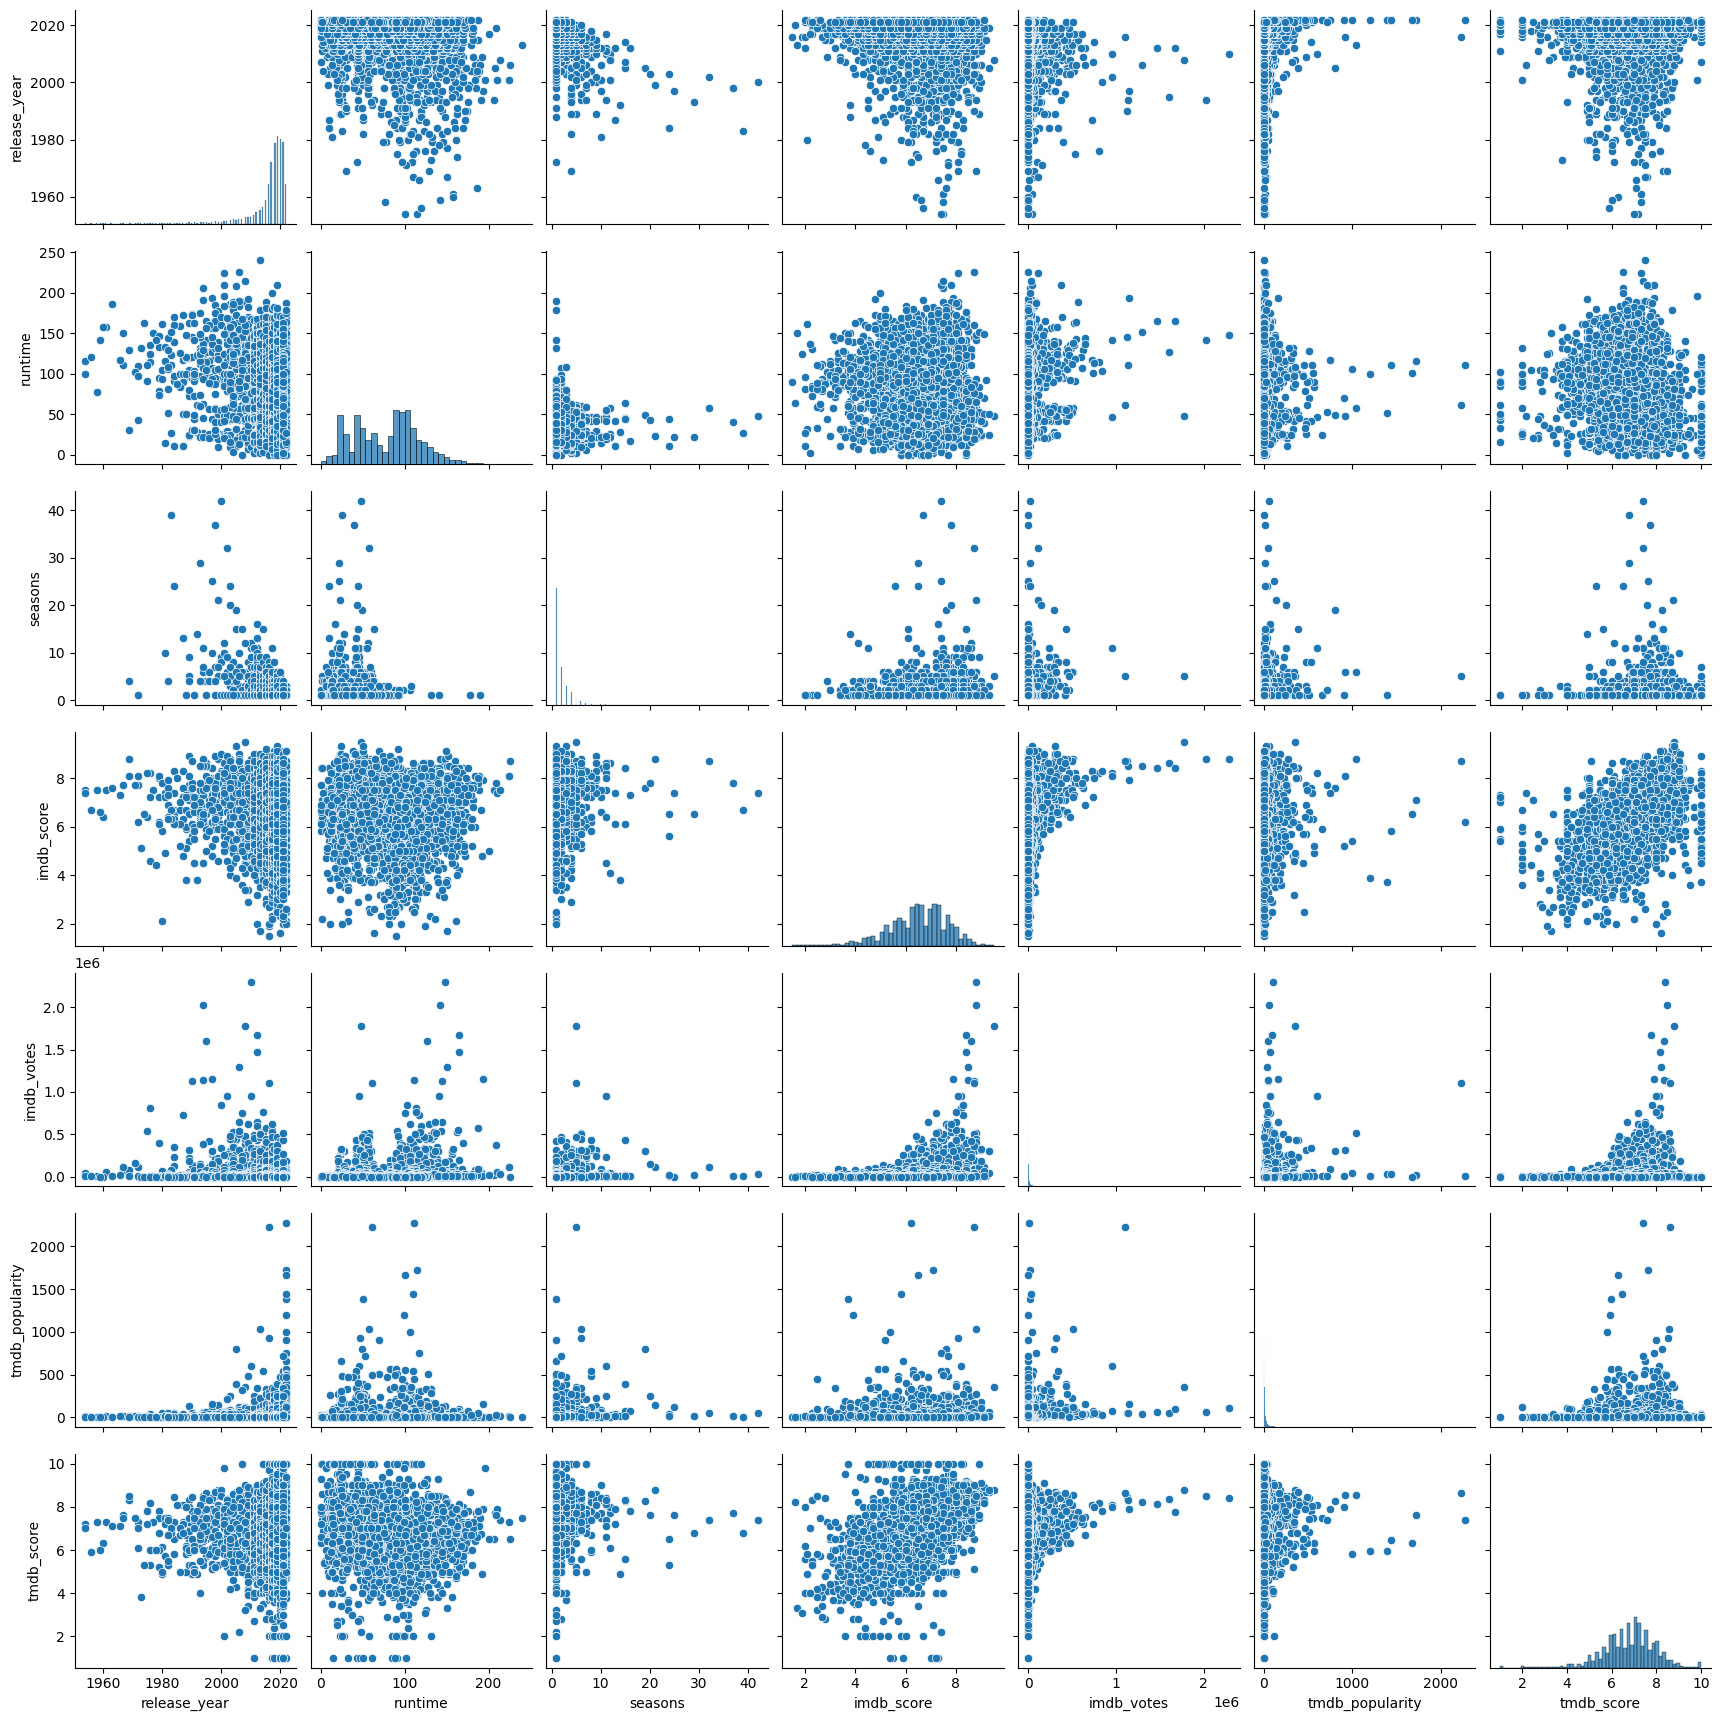

In [179]:
sns.pairplot(media_df)
corr_matrix = media_df.corr(numeric_only=True)
corr_matrix

### Correlations with imdb

In [180]:
corr_matrix['imdb_score'].sort_values(ascending=False)

imdb_score         1.000000
tmdb_score         0.587753
imdb_votes         0.197259
seasons            0.104950
tmdb_popularity    0.018180
release_year      -0.130013
runtime           -0.147415
Name: imdb_score, dtype: float64

## Line graph showing correlation of imdb_score vs tmdb_score

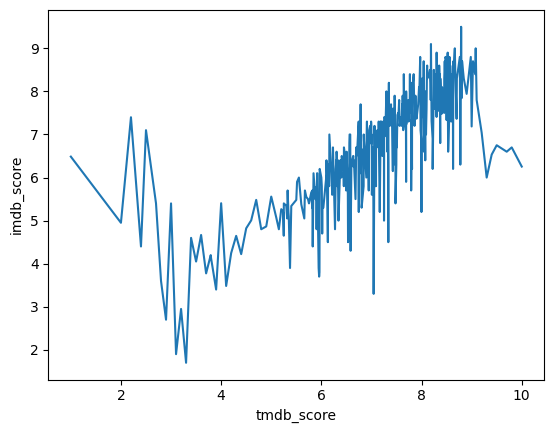

In [181]:
g = sns.lineplot(x="tmdb_score", y="imdb_score", data=media_df, errorbar=None)

## Line graph showing the imdb_score vs tmdb_score over time

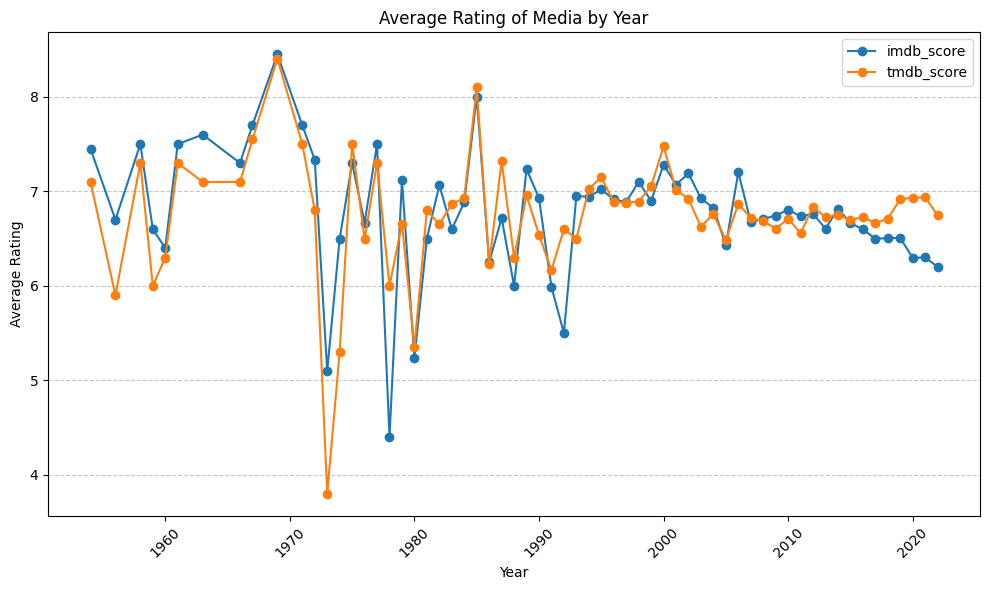

In [182]:
# Rating of movies and shows over time
score_columns = ['imdb_score','tmdb_score']
avg_media_ratings = media_df.groupby('release_year')[score_columns].mean()

def plot_avg_rating_by_year(avg_ratings):
    plt.figure(figsize=(10, 6))
    
    for column in score_columns:
        plt.plot(avg_ratings.index, avg_ratings[column], marker='o', linestyle='-', label=column)
    
    # Plot line graphs
    plt.title('Average Rating of Media by Year')
    plt.xlabel('Year')
    plt.ylabel('Average Rating')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

plot_avg_rating_by_year(avg_media_ratings)

## Line graph showing correlation of imdb_score vs imdb_votes

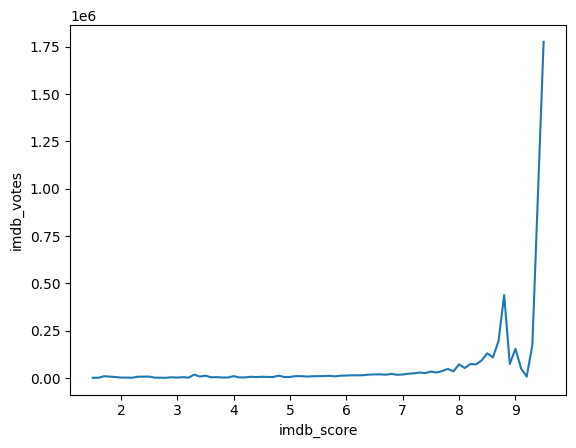

In [183]:
g = sns.lineplot(x="imdb_score", y="imdb_votes", data=media_df, errorbar=None)

## Scatter plot showing correlation of imdb_score vs imdb_votes

Text(0, 0.5, 'imdb_votes')

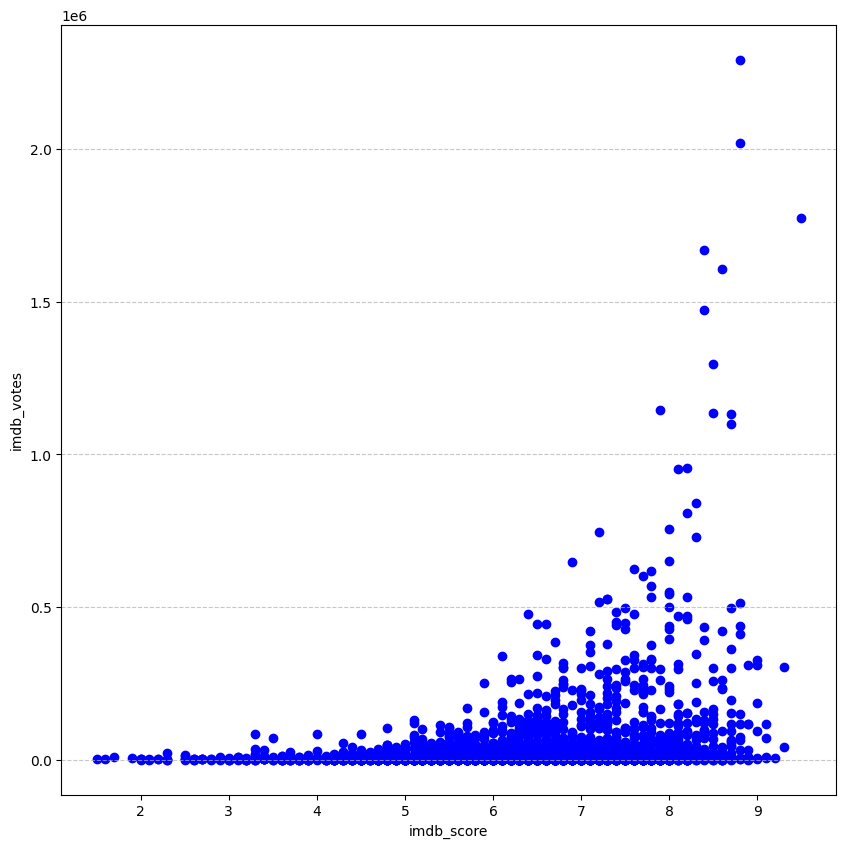

In [184]:
X = media_df["imdb_score"]
y = media_df["imdb_votes"]

fig, pl = plt.subplots(figsize=(10, 10))
pl.scatter(X, y, color = 'b')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlabel("imdb_score")
plt.ylabel("imdb_votes")

## Correlation between imdb_score and filmmakers average cumulative media imdb scores

### Here we add two new columns that refer to the cumulative average imdb scores of the actors and directors for each piece of media

In [185]:
# Merge titles dataframe with credits dataframe
combined_df = pd.merge(titles_df, credits_df, left_on = "id", right_on = "id")

actor_df=combined_df[combined_df['role']=='ACTOR']
director_df=combined_df[combined_df['role']=='DIRECTOR']

# Calculate average scores for actors and directors
actors_avg_scores = actor_df.groupby('person_id')['imdb_score'].mean().reset_index()
directors_avg_scores = director_df.groupby('person_id')['imdb_score'].mean().reset_index()

# Function to calculate cumulative average score
def calculate_cumulative_avg(person_ids, avg_scores_df):
    scores = avg_scores_df[avg_scores_df['person_id'].isin(person_ids)]['imdb_score']

    if len(scores) == 0:
        return None
    return scores.mean()

# Apply the function to each row in 'media_df' and create new columns
media_df['cumulative_avg_actor_score'] = media_df['actor_ids'].apply(lambda x: calculate_cumulative_avg(x, actors_avg_scores))
media_df['cumulative_avg_director_score'] = media_df['director_ids'].apply(lambda x: calculate_cumulative_avg(x, directors_avg_scores))

media_df

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,...,imdb_votes,tmdb_popularity,tmdb_score,character,actor,director,actor_ids,director_ids,cumulative_avg_actor_score,cumulative_avg_director_score
0,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],NaN,...,808582.0,40.965,8.179,"[Travis Bickle, Iris Steensma, Tom, Matthew 'S...","[Robert De Niro, Jodie Foster, Albert Brooks, ...",[Martin Scorsese],"[3748, 14658, 7064, 3739, 48933, 32267, 519612...",[3308],7.983333,8.16
1,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,"['drama', 'action', 'thriller', 'european']",['US'],NaN,...,107673.0,10.010,7.300,"[Ed Gentry, Lewis Medlock, Bobby Trippe, Drew ...","[Jon Voight, Burt Reynolds, Ned Beatty, Ronny ...",[John Boorman],"[10103, 13020, 6639, 11224, 24509, 80069, 8403...",[17727],7.521970,7.70
2,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,...,534486.0,15.461,7.811,[King Arthur / Voice of God / Middle Head / Hi...,"[Graham Chapman, John Cleese, Eric Idle, Terry...","[Terry Jones, Terry Gilliam]","[11472, 1549, 11474, 11473, 11475, 11476, 4089...","[11475, 11473]",8.142933,8.15
3,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,NaN,150,"['war', 'action']","['GB', 'US']",NaN,...,72662.0,20.398,7.600,"[Maj. John Reisman, Maj. Gen. Worden, Joseph W...","[Lee Marvin, Ernest Borgnine, Charles Bronson,...",[Robert Aldrich],"[35196, 1050, 16868, 14351, 35197, 35200, 1061...",[1063],7.686111,7.70
4,ts22164,Monty Python's Flying Circus,SHOW,A British sketch comedy series with the shows ...,1969,TV-14,30,"['comedy', 'european']",['GB'],4.0,...,73424.0,17.617,8.306,"[Various, Various / ""It's"" man, Various, Vario...","[Graham Chapman, Michael Palin, Terry Jones, E...",[],"[11472, 11476, 11475, 11474, 11473]",[],7.952042,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5484,tm1216735,Sun of the Soil,MOVIE,"In 14th-century Mali, an ambitious young royal...",2022,NaN,26,[],[],NaN,...,NaN,1.179,7.000,[nan],[],[Joe Penney],[],[1785287],NaN,NaN
5485,tm985215,Princess 'Daya'Reese,MOVIE,Reese is a con artist from Manila who dreams o...,2021,NaN,115,"['comedy', 'romance']",['PH'],NaN,...,50.0,1.383,NaN,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[Maymay Entrata, Edward Barber, Snooky Serna, ...",[Barry Gonzalez],"[757428, 757395, 134442, 143411, 206514, 26073...",[753271],6.731270,4.80
5486,tm1097142,My Bride,MOVIE,The story follows a young man and woman who go...,2021,NaN,93,"['romance', 'comedy', 'drama']",['EG'],NaN,...,327.0,2.545,5.300,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[Ahmed Hatem, Jamila Awad, Mahmoud Al-Bezzawy,...",[Mohamed Bakir],"[247928, 710979, 1813868, 817494, 1459769, 119...",[1827884],5.068889,5.00
5487,tm1014599,Fine Wine,MOVIE,A beautiful love story that can happen between...,2021,NaN,100,"['romance', 'drama']",['NG'],NaN,...,45.0,1.466,NaN,"[Mr. George, Kaima, Akin, Tunji, Temisan, nan,...","[Richard Mofe-Damijo, Ego Nwosu, Keppy Ekpenyo...",[Seyi Babatope],"[269015, 2151684, 361605, 1018894, 618764, 678...",[1962840],6.035909,5.05


,release_year,runtime,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,cumulative_avg_actor_score,cumulative_avg_director_score
release_year,1.000000,-0.177101,-0.535886,-0.130013,-0.208240,0.046217,0.029133,-0.133388,-0.115726
runtime,-0.177101,1.000000,-0.151898,-0.147415,0.134900,-0.007768,-0.271951,-0.123253,-0.056355
seasons,-0.535886,-0.151898,1.000000,0.104950,0.204067,0.166052,0.048226,0.063692,-0.040094
imdb_score,-0.130013,-0.147415,0.104950,1.000000,0.197259,0.018180,0.587753,0.940292,0.933886
imdb_votes,-0.208240,0.134900,0.204067,0.197259,1.000000,0.207808,0.121751,0.180997,0.166000
tmdb_popularity,0.046217,-0.007768,0.166052,0.018180,0.207808,1.000000,0.079296,0.008737,-0.037726
tmdb_score,0.029133,-0.271951,0.048226,0.587753,0.121751,0.079296,1.000000,0.529032,0.581226
cumulative_avg_actor_score,-0.133388,-0.123253,0.063692,0.940292,0.180997,0.008737,0.529032,1.000000,0.904946
cumulative_avg_director_score,-0.115726,-0.056355,-0.040094,0.933886,0.166000,-0.037726,0.581226,0.904946,1.000000


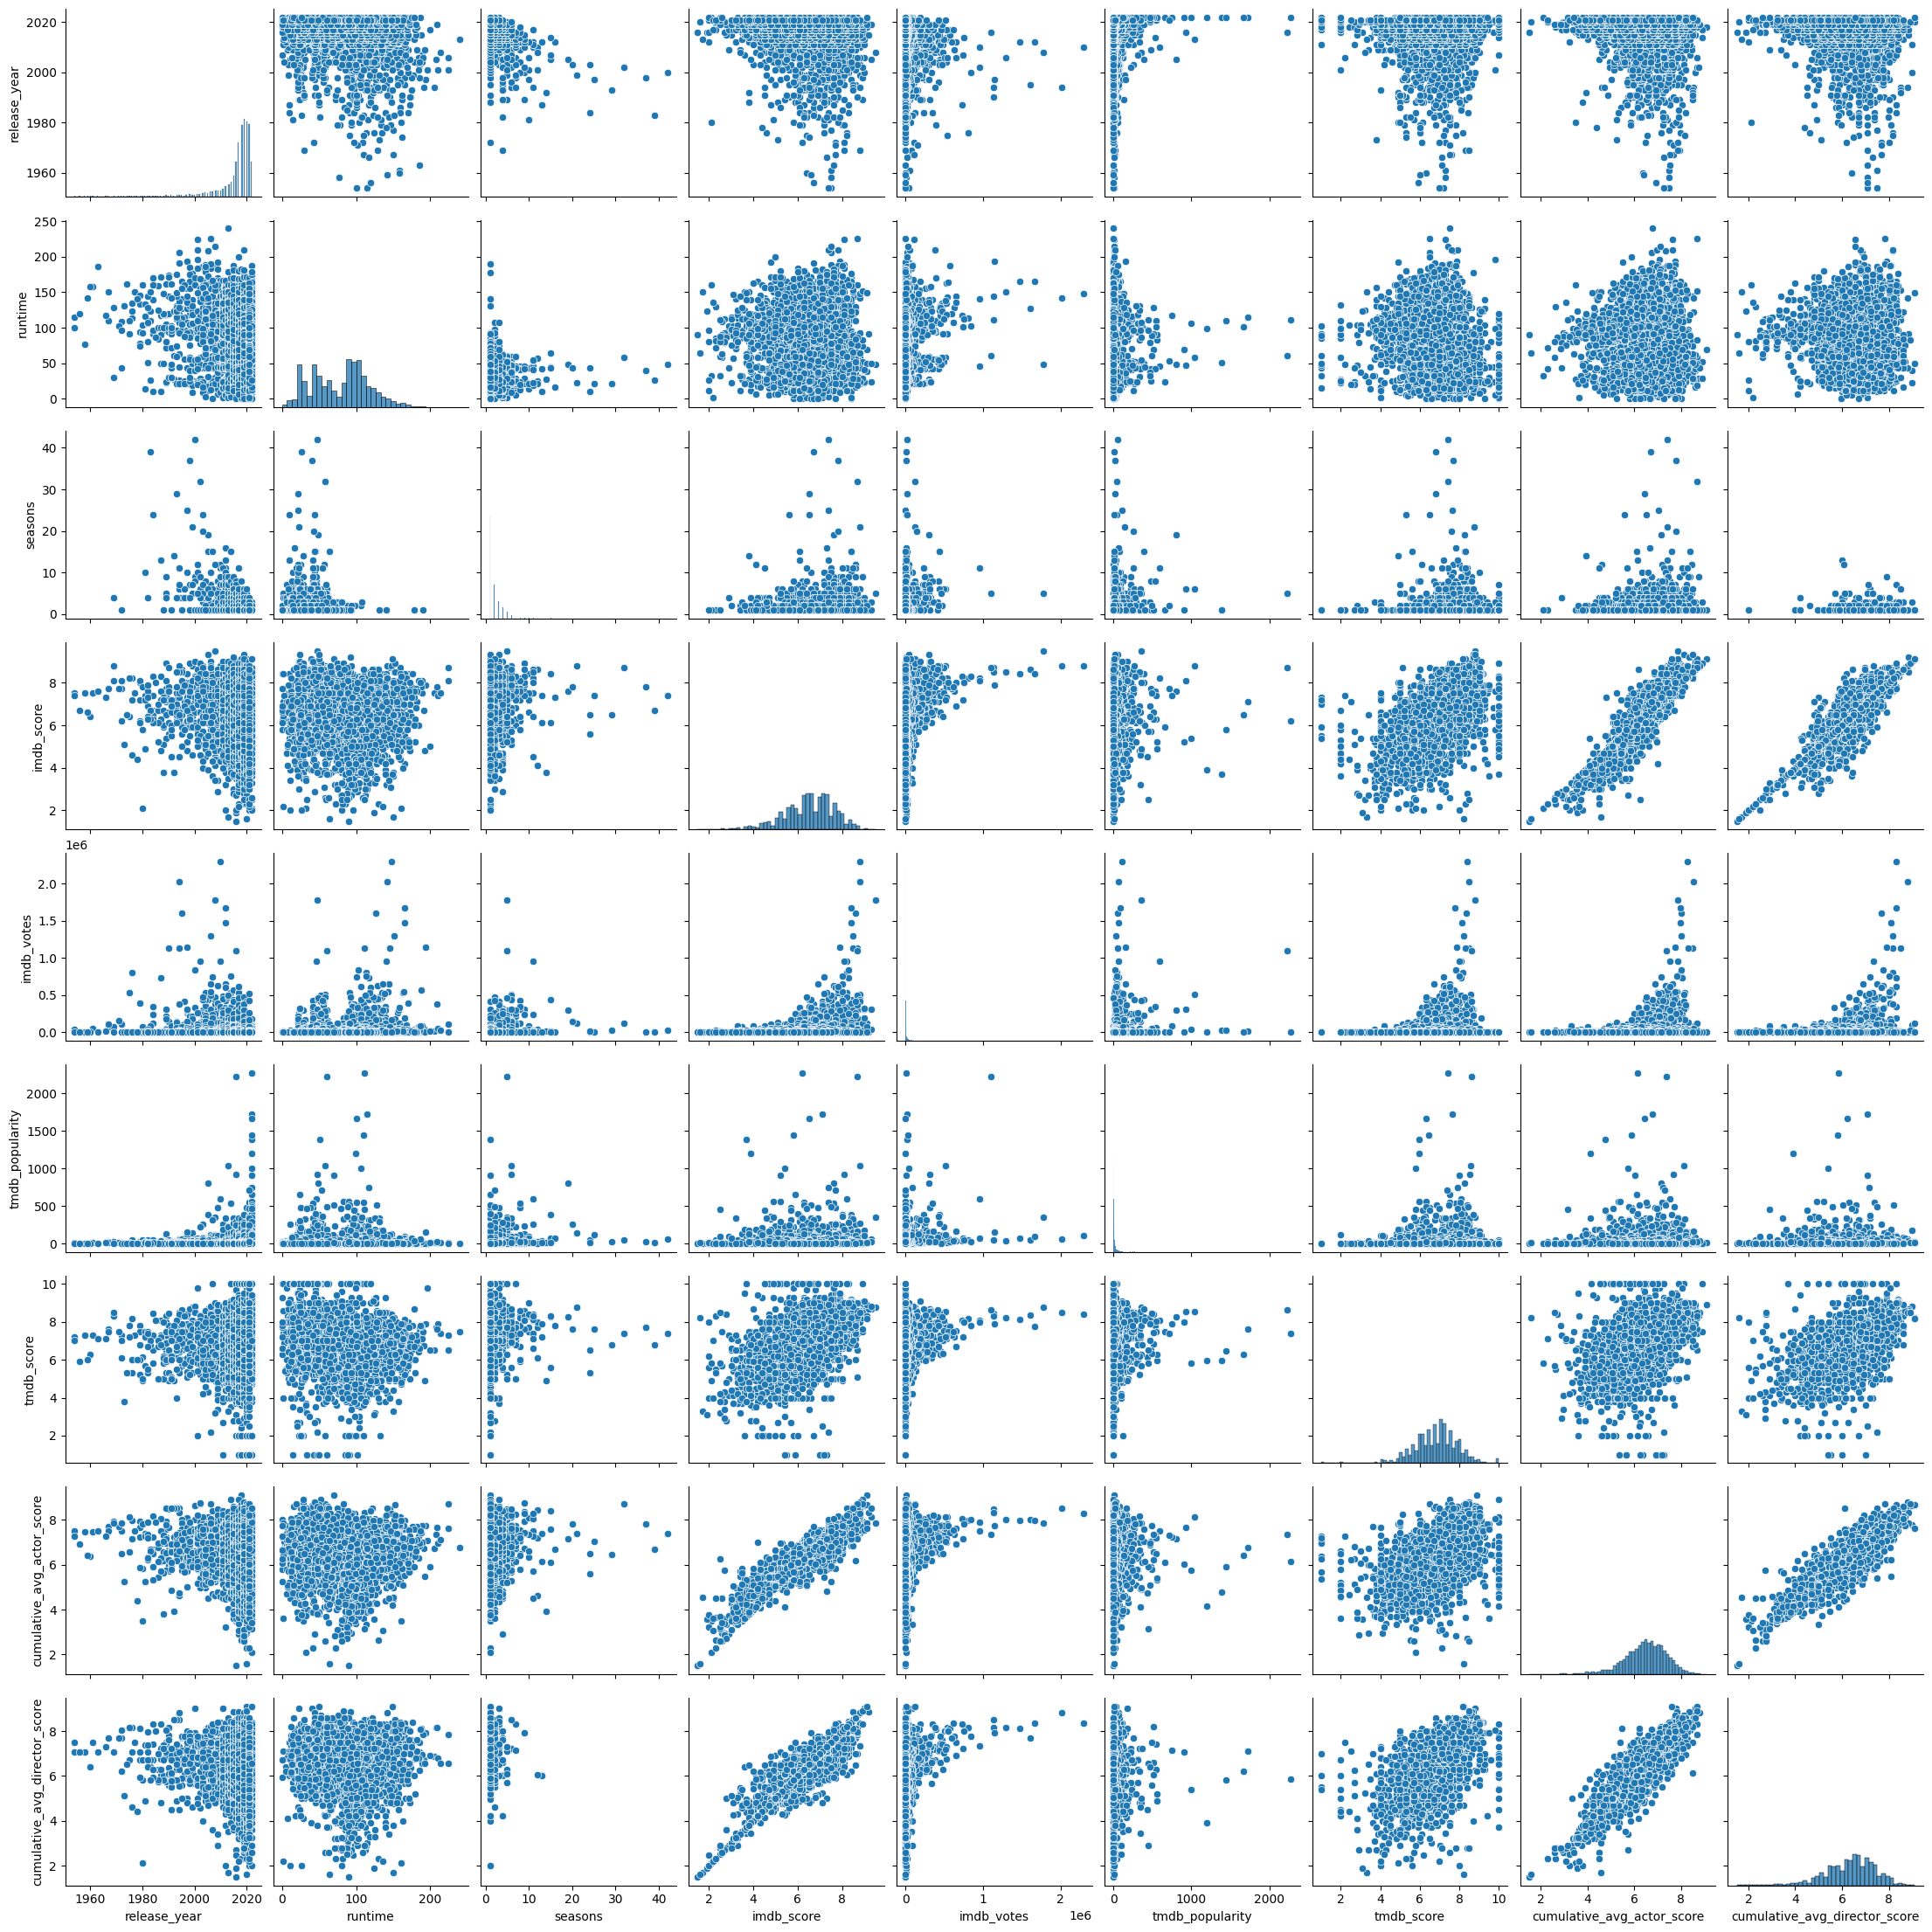

In [186]:
sns.pairplot(media_df)
corr_matrix_new = media_df.corr(numeric_only=True)
corr_matrix_new

# Data Cleaning

Remove all unnecessary data based on correlations gathered from previous observations.

In [187]:
# Data cleaning
media_df = media_df.drop(columns=['imdb_id','tmdb_popularity','tmdb_score','character'], axis=1)
media_df.dropna(subset=['title','imdb_score','imdb_votes'], inplace=True)
media_df['seasons']=media_df['seasons'].fillna(0)

media_df.reset_index().head()

,index,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_score,imdb_votes,actor,director,actor_ids,director_ids,cumulative_avg_actor_score,cumulative_avg_director_score
0,0,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],0.0,8.2,808582.0,"[Robert De Niro, Jodie Foster, Albert Brooks, ...",[Martin Scorsese],"[3748, 14658, 7064, 3739, 48933, 32267, 519612...",[3308],7.983333,8.16
1,1,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,"['drama', 'action', 'thriller', 'european']",['US'],0.0,7.7,107673.0,"[Jon Voight, Burt Reynolds, Ned Beatty, Ronny ...",[John Boorman],"[10103, 13020, 6639, 11224, 24509, 80069, 8403...",[17727],7.521970,7.70
2,2,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],0.0,8.2,534486.0,"[Graham Chapman, John Cleese, Eric Idle, Terry...","[Terry Jones, Terry Gilliam]","[11472, 1549, 11474, 11473, 11475, 11476, 4089...","[11475, 11473]",8.142933,8.15
3,3,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,NaN,150,"['war', 'action']","['GB', 'US']",0.0,7.7,72662.0,"[Lee Marvin, Ernest Borgnine, Charles Bronson,...",[Robert Aldrich],"[35196, 1050, 16868, 14351, 35197, 35200, 1061...",[1063],7.686111,7.70
4,4,ts22164,Monty Python's Flying Circus,SHOW,A British sketch comedy series with the shows ...,1969,TV-14,30,"['comedy', 'european']",['GB'],4.0,8.8,73424.0,"[Graham Chapman, Michael Palin, Terry Jones, E...",[],"[11472, 11476, 11475, 11474, 11473]",[],7.952042,NaN
